In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from pathlib import Path
from collections import defaultdict
import shutil
from sklearn.utils import resample
import seaborn as sns
from matplotlib.patches import Patch

In [8]:
# Unzip the file
# zip_paths = [
#     "/content/sample_data/bending1.zip",
#     "/content/sample_data/bending2.zip",
#     "/content/sample_data/walking.zip",
#     "/content/sample_data/standing.zip",
#     "/content/sample_data/sitting.zip",
#     "/content/sample_data/lying.zip",
#     "/content/sample_data/cycling.zip"
# ]
zip_paths = [
    "bending1.zip",
    "bending2.zip",
    "walking.zip",
    "standing.zip",
    "sitting.zip",
    "lying.zip",
    "cycling.zip"
]
# extract_base_path = "/content/sample_data/time_series_data"
extract_base_path = "time_series_data"
for zip_path in zip_paths:
    activity_name = Path(zip_path).stem
    extract_path = os.path.join(extract_base_path, activity_name)
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [39]:
# Problem b
# Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
# 2, and 3 in other folders as test data and other datasets as train data.

all_files = list(Path(extract_base_path).glob("**/*.csv"))
activity_files = defaultdict(list)
for file in all_files:
    activity = file.parent.name
    activity_files[activity].append(file)
test_files = []
train_files = []
for activity, files in activity_files.items():
    sorted_files = sorted(files, key=lambda f: int(f.stem.replace("dataset", "")))
    if activity in ["bending1", "bending2"]:
        test_files.extend(sorted_files[:2])
        train_files.extend(sorted_files[2:])
    else:
        test_files.extend(sorted_files[:3])
        train_files.extend(sorted_files[3:])
def build_dataset_index(file_list, set_type):
    data = []
    for file_path in file_list:
        activity = Path(file_path).parent.name
        data.append({"filepath": str(file_path), "activity": activity, "set": set_type})
    return pd.DataFrame(data)

test_df = build_dataset_index(test_files, "test")
train_df = build_dataset_index(train_files, "train")
full_index_df = pd.concat([train_df, test_df])
full_index_df.to_csv("/content/sample_data/split.csv")

In [40]:
# Extract the time-domain features minimum, maximum, mean, median, standard deviation,
# first quartile, and third quartile for all of the 6 time series in each instance.
# Normalize/Standardize features or use them directly.

feature_types = ['min', 'max', 'mean', 'median', 'std', '1st_quart', '3rd_quart']
columns = [f"{feat}_{i}" for i in range(1, 7) for feat in feature_types]

# Extract the features
def extract_features_from_csv(csv_path):
    try:
        df = pd.read_csv(csv_path, comment='#', header=None)
        data = df.iloc[:, 1:7].astype(float)
        features = []
        for i in range(6):
            series = data.iloc[:, i]
            stats = [
                np.min(series),
                np.max(series),
                np.mean(series),
                np.median(series),
                np.std(series),
                np.percentile(series, 25),
                np.percentile(series, 75)
            ]
            features.extend(stats)
        return features
    except Exception as e:
        print(f"Error processing {csv_path}: {e}")
        return None
train_test = test_files + train_files
all_feature_rows = []
for file_path in train_test:
    features = extract_features_from_csv(file_path)
    if features:
        all_feature_rows.append(features)
feature_df = pd.DataFrame(all_feature_rows, columns=columns)
feature_df.insert(0, "Instance", range(1, len(feature_df) + 1))
print(feature_df.to_string(index=False))

 Instance  min_1  max_1    mean_1  median_1    std_1  1st_quart_1  3rd_quart_1  min_2  max_2   mean_2  median_2    std_2  1st_quart_2  3rd_quart_2  min_3  max_3    mean_3  median_3    std_3  1st_quart_3  3rd_quart_3  min_4  max_4   mean_4  median_4    std_4  1st_quart_4  3rd_quart_4  min_5  max_5    mean_5  median_5    std_5  1st_quart_5  3rd_quart_5  min_6  max_6   mean_6  median_6    std_6  1st_quart_6  3rd_quart_6
        1  12.75  51.00 24.562958    24.250 3.733619      23.1875      26.5000    0.0   6.87 0.590833     0.430 0.836535       0.0000       0.7100   0.00  25.33 19.121333    20.250 4.295131      18.0000      22.0000    0.0   6.76 0.736771     0.470 0.926081       0.0000       0.8700  10.67  30.00 23.493042    23.750 3.689936      20.5000      27.0000   0.00   4.97 0.700188     0.500 0.692997       0.4300       0.8700
        2   0.00  42.75 27.464604    28.000 3.579847      25.5000      30.0000    0.0   7.76 0.449708     0.430 0.766397       0.0000       0.5000   7.50  35.

In [42]:
# build a 90% bootsrap confidence interval for the standard deviationo for each feature
def bootstrap(data, n_bootstrap=1000, ci=90):
    stat = []
    for _ in range(n_bootstrap):
        sample = resample(data)
        stat.append(np.std(sample))
    lower = np.percentile(stat, (100 - ci) / 2)
    upper = np.percentile(stat, 100 - (100 - ci) / 2)
    return np.std(data), lower, upper
ci_result = []
for col in columns:
    std, ci_lower, ci_upper = bootstrap(feature_df[col])
    ci_result.append({
        'Features': col,
        'Standard Deviation': std,
        'Confidence Interval(Lower)': ci_lower,
        'Confidence Interval(Upper)': ci_upper
    })
ci_df = pd.DataFrame(ci_result)
print(ci_df.to_string(index=False))

   Features  Standard Deviation  Confidence Interval(Lower)  Confidence Interval(Upper)
      min_1            9.515445                    8.203223                   10.689057
      max_1            4.369322                    3.330802                    5.245265
     mean_1            5.305314                    4.687613                    5.861930
   median_1            5.409056                    4.750101                    6.012320
      std_1            1.760219                    1.562107                    1.937162
1st_quart_1            6.118526                    5.522451                    6.579131
3rd_quart_1            5.109643                    4.307212                    5.762447
      min_2            0.000000                    0.000000                    0.000000
      max_2            5.033882                    4.598136                    5.372982
     mean_2            1.565194                    1.384270                    1.692809
   median_2            1.404197 

Three important features:Mean,Std,Max

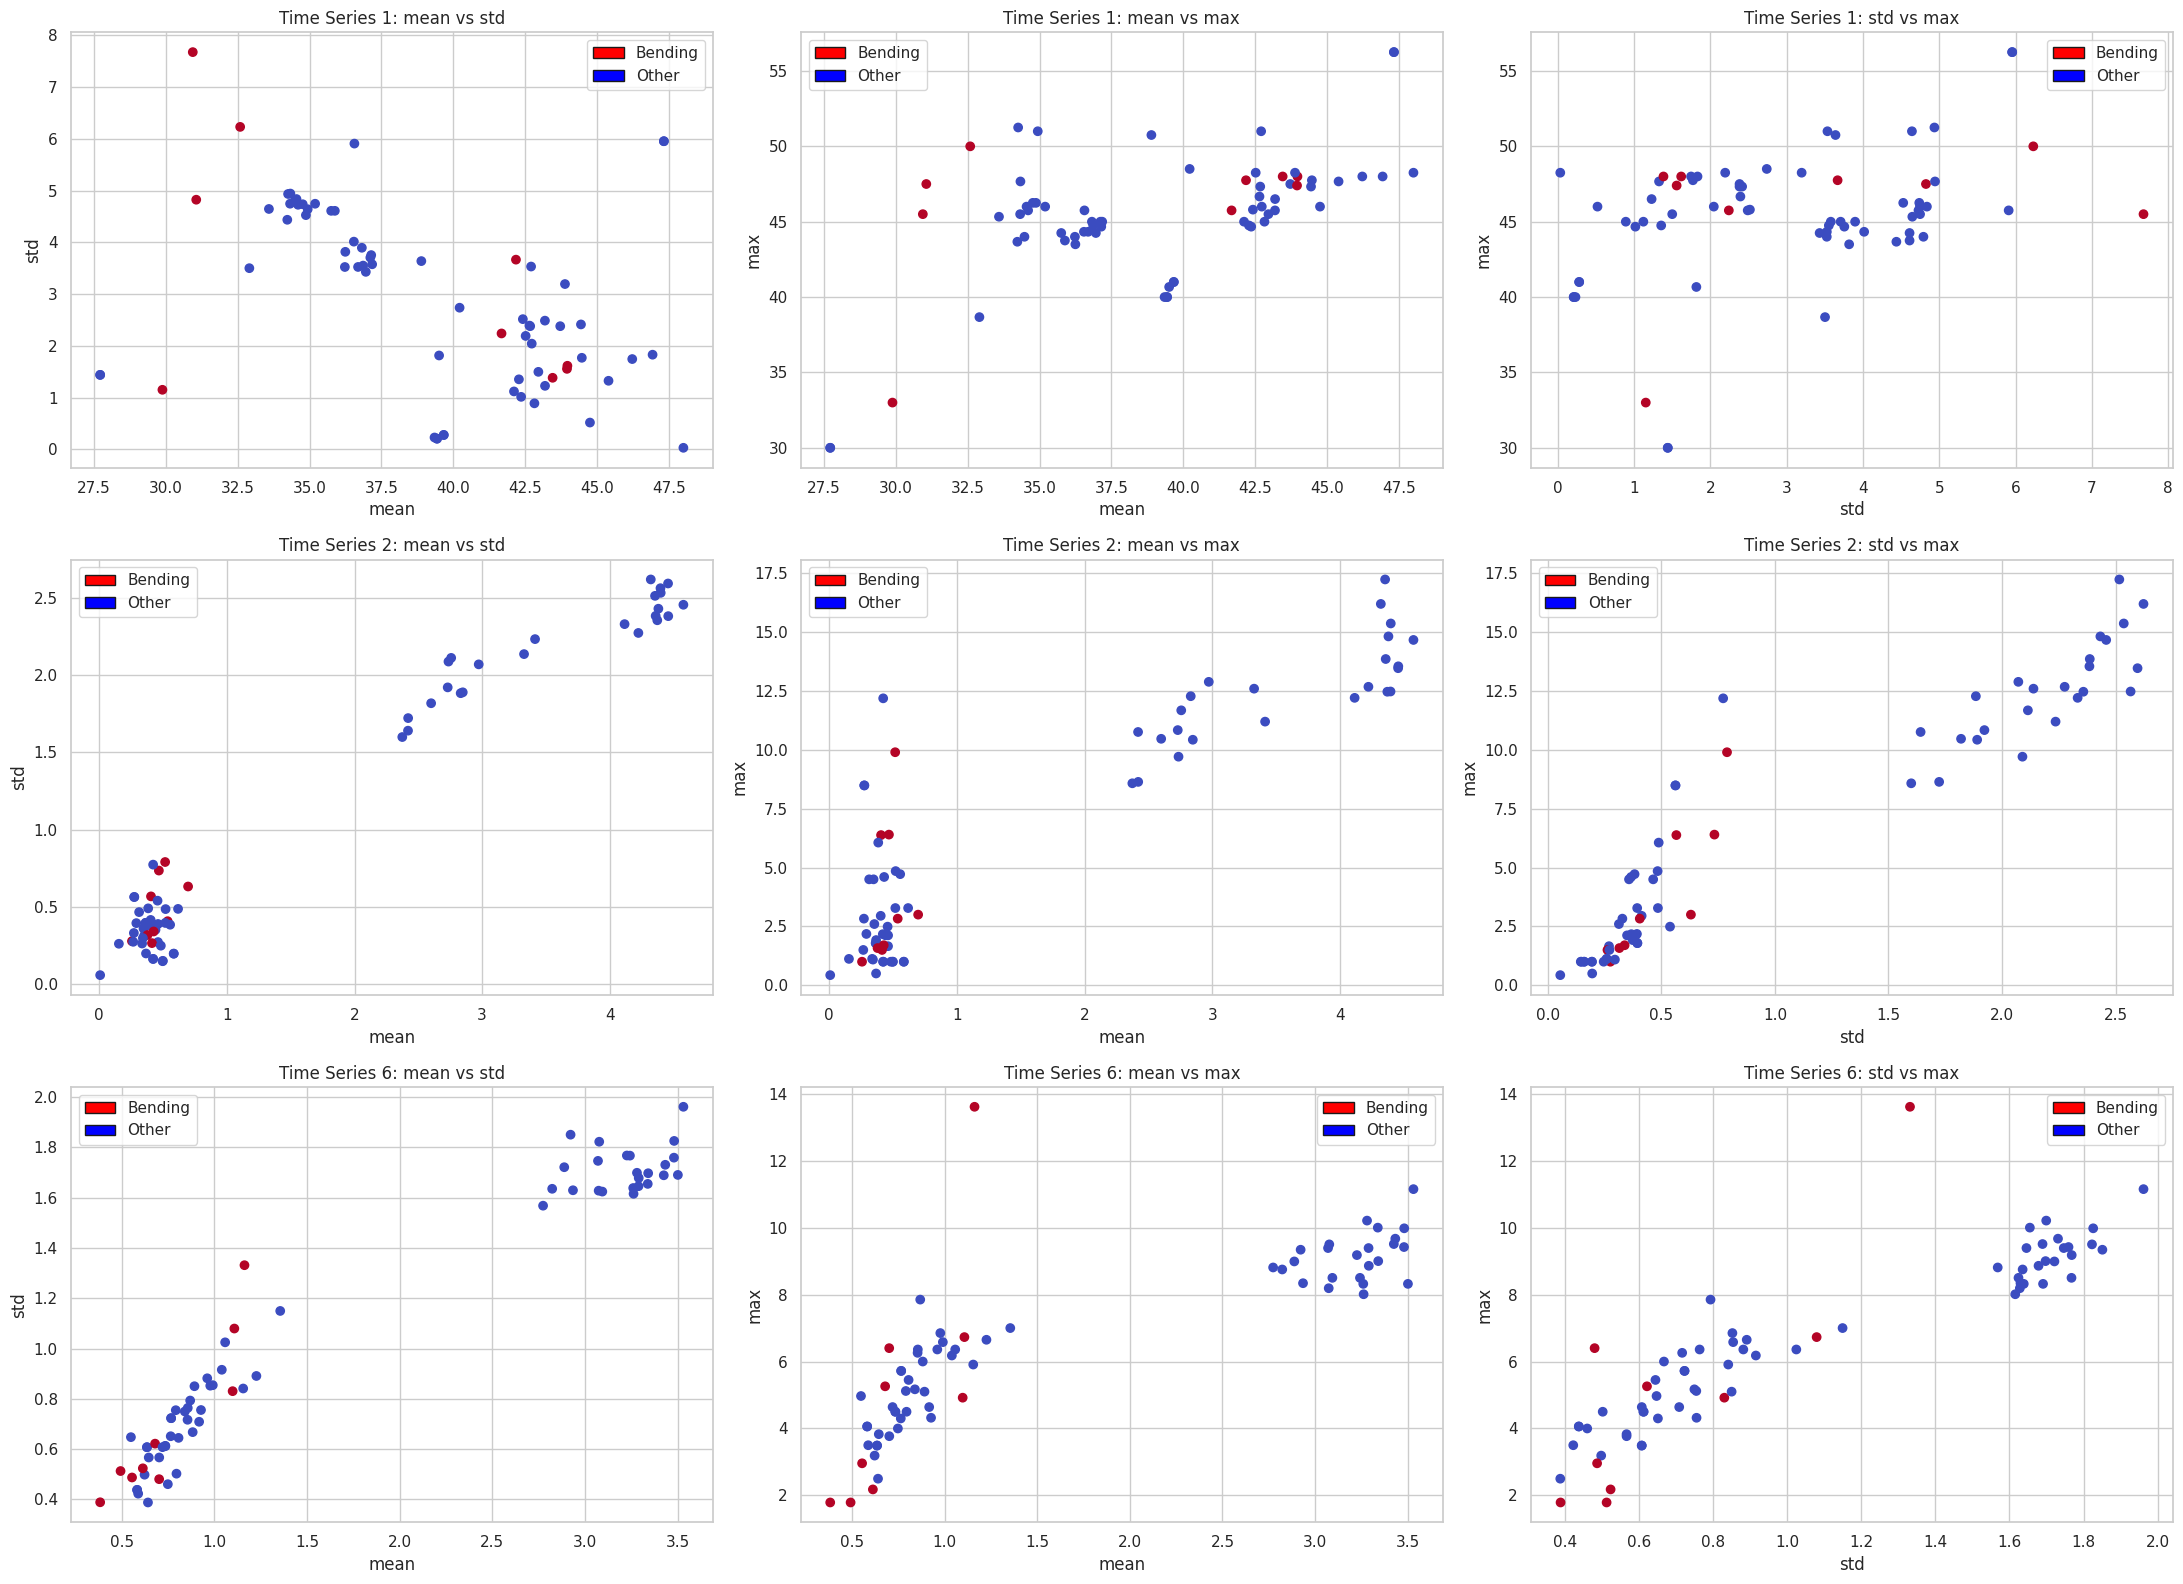

In [41]:
# Assume that you want to use the training set to classify bending from other
# activities, i.e. you have a binary classification problem. Depict scatter plots
# of the features you specified in 7(c)iv extracted from time series 1, 2, and 6 of
# each instance, and use color to distinguish bending vs. other activities.

spilt_df = pd.read_csv("/content/sample_data/split.csv")
train_df_index = spilt_df[spilt_df["set"] == "train"]
feature_rows = []
labels = []
for _, row in train_df_index.iterrows():
    features = extract_features_from_csv(row["filepath"])
    if features:
        feature_rows.append(features)
        labels.append(1 if row["activity"] in ["bending1", "bending2"] else 0)
train_features = pd.DataFrame(feature_rows, columns=columns)
train_features["Bending"] = labels

plt.figure(figsize=(22, 16))
for row_idx, ts in enumerate([1, 2, 6]):
    mean_col = f"mean_{ts}"
    std_col = f"std_{ts}"
    max_col = f"max_{ts}"

    plt.subplot(3, 3, row_idx * 3 + 1)
    plt.scatter(train_features[mean_col], train_features[std_col],
                c=train_features["Bending"], cmap="coolwarm")
    plt.xlabel(f"mean")
    plt.ylabel(f"std")
    plt.title(f"Time Series {ts}: mean vs std")
    plt.legend(handles=[
        Patch(facecolor='red', edgecolor='k', label='Bending'),
        Patch(facecolor='blue', edgecolor='k', label='Other')
    ])

    plt.subplot(3, 3, row_idx * 3 + 2)
    plt.scatter(train_features[mean_col], train_features[max_col],
                c=train_features["Bending"], cmap="coolwarm")
    plt.xlabel(f"mean")
    plt.ylabel(f"max")
    plt.title(f"Time Series {ts}: mean vs max")

    plt.legend(handles=[
        Patch(facecolor='red', edgecolor='k', label='Bending'),
        Patch(facecolor='blue', edgecolor='k', label='Other')
    ])

    plt.subplot(3, 3, row_idx * 3 + 3)
    plt.scatter(train_features[std_col], train_features[max_col],
                c=train_features["Bending"], cmap="coolwarm")
    plt.xlabel(f"std")
    plt.ylabel(f"max")
    plt.title(f"Time Series {ts}: std vs max")
    plt.legend(handles=[
        Patch(facecolor='red', edgecolor='k', label='Bending'),
        Patch(facecolor='blue', edgecolor='k', label='Other')
    ])

plt.tight_layout()
plt.show()

In [ ]:
if row_idx == 0:
        plt.legend(handles=[
            Patch(facecolor='red', edgecolor='k', label='Bending'),
            Patch(facecolor='blue', edgecolor='k', label='Other')
        ], title="Activity", loc='best')